In [1]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from  nltk.stem import SnowballStemmer



# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# DATASET
DATASET_COLUMNS = ["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9']+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


Using TensorFlow backend.


## 트윗 전처리

In [2]:
dataset="C:/Users/castl/Desktop/2020_job_academy/project/emotion_analysis/input/tweets_10man.csv"
df=pd.read_csv(dataset,encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [3]:
df.head(5)

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [5]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 81.1 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

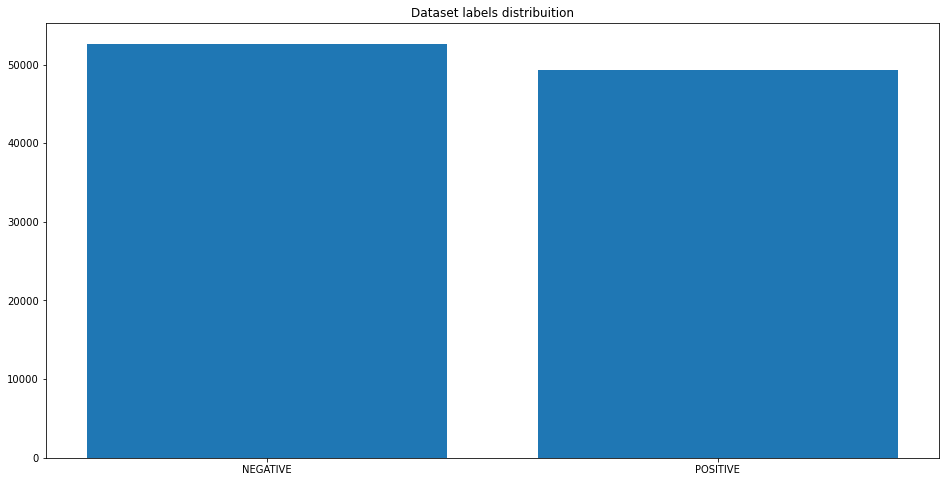

In [6]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [7]:
## 불용어 사전제작

garbage_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
stemmer = SnowballStemmer("english")

In [8]:
def preprocess(text, stem=False):
    # 불필요한 불용어 및 특수문자, id 등 제거
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in garbage_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


In [9]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 6.27 s


In [10]:
preprocess(df.head(5))

"target text 0 negative awww that's bummer shoulda got david carr thir 1 negative upset can't update facebook texting might cry 2 negative dived many times ball managed save 50 rest go 3 negative whole body feels itchy like fire 4 negative no it's not behaving i'm mad can't see"

In [11]:
# 훈련세트, 테스트세트 분할 하기

df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 81600
TEST size: 20400


In [12]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 399 ms


In [14]:
# word2Vec 사용하여 유사단어, 네가티브 셈플링 기능 사용

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [15]:
w2v_model.build_vocab(documents)

2020-08-27 23:37:41,444 : INFO : collecting all words and their counts
2020-08-27 23:37:41,445 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-27 23:37:41,486 : INFO : PROGRESS: at sentence #10000, processed 76644 words, keeping 14019 word types
2020-08-27 23:37:41,524 : INFO : PROGRESS: at sentence #20000, processed 152719 words, keeping 21598 word types
2020-08-27 23:37:41,572 : INFO : PROGRESS: at sentence #30000, processed 229135 words, keeping 27718 word types
2020-08-27 23:37:41,614 : INFO : PROGRESS: at sentence #40000, processed 305514 words, keeping 33064 word types
2020-08-27 23:37:41,651 : INFO : PROGRESS: at sentence #50000, processed 381987 words, keeping 37979 word types
2020-08-27 23:37:41,699 : INFO : PROGRESS: at sentence #60000, processed 457873 words, keeping 42588 word types
2020-08-27 23:37:41,752 : INFO : PROGRESS: at sentence #70000, processed 534613 words, keeping 46821 word types
2020-08-27 23:37:41,799 : INFO : PROGRESS: at s

In [16]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 5564


In [17]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-08-27 23:37:53,074 : INFO : training model with 8 workers on 5564 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-08-27 23:37:54,008 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-27 23:37:54,016 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-27 23:37:54,018 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-27 23:37:54,025 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-27 23:37:54,027 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-27 23:37:54,039 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-27 23:37:54,045 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-27 23:37:54,049 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-27 23:37:54,051 : INFO : EPOCH - 1 : training on 622407 raw words (488362 effective words) took 1.0s, 509551 effect

2020-08-27 23:38:02,800 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-27 23:38:02,813 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-27 23:38:02,815 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-27 23:38:02,818 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-27 23:38:02,819 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-27 23:38:02,837 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-27 23:38:02,840 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-27 23:38:02,841 : INFO : EPOCH - 10 : training on 622407 raw words (488879 effective words) took 1.0s, 504234 effective words/s
2020-08-27 23:38:03,673 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-27 23:38:03,677 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-27 23:38:03,687 : INFO : worker threa

2020-08-27 23:38:11,568 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-27 23:38:11,571 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-27 23:38:11,571 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-27 23:38:11,571 : INFO : EPOCH - 19 : training on 622407 raw words (488251 effective words) took 0.9s, 565348 effective words/s
2020-08-27 23:38:12,469 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-27 23:38:12,474 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-27 23:38:12,475 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-27 23:38:12,482 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-27 23:38:12,497 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-27 23:38:12,502 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-27 23:38:12,513 : INFO : worker threa

2020-08-27 23:38:20,470 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-27 23:38:20,491 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-27 23:38:20,497 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-27 23:38:20,499 : INFO : EPOCH - 28 : training on 622407 raw words (488202 effective words) took 1.0s, 502712 effective words/s
2020-08-27 23:38:21,404 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-27 23:38:21,413 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-27 23:38:21,415 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-27 23:38:21,417 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-27 23:38:21,419 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-27 23:38:21,423 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-27 23:38:21,440 : INFO : worker threa

Wall time: 31.2 s


(15631397, 19917024)

In [18]:
w2v_model.most_similar("upset")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-08-27 23:38:24,313 : INFO : precomputing L2-norms of word weight vectors


[('disappointed', 0.43429937958717346),
 ('surprised', 0.42016732692718506),
 ('pregnant', 0.4148280620574951),
 ('worried', 0.389645516872406),
 ('annoyed', 0.38089796900749207),
 ('mad', 0.37214556336402893),
 ('sry', 0.3637915253639221),
 ('bummed', 0.3487834334373474),
 ('lonely', 0.3473183810710907),
 ('pissed', 0.34531331062316895)]

In [19]:
# 문장 토큰화

%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 51227
Wall time: 2.97 s


In [20]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 4.31 s


In [21]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [22]:
#label encoder을 통해 문자를 숫자로 변환

encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

# 모든 원소가 빠지지 않도록 하나씩 재구성
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (81600, 1)
y_test (20400, 1)


In [23]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (81600, 300)
y_train (81600, 1)

x_test (20400, 300)
y_test (20400, 1)


In [24]:
# 앞서 사용한 Word2Vec을 이용하여 embedding layer 쌓기

embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

print(embedding_matrix.shape)

(51227, 300)


In [25]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [26]:
# sequential block을 사용하여 embedding layer, dropout(정규화),LSTM, dense 층을 쌓음

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) #RNN의 한종류인 LSTM 사용
model.add(Dense(1, activation='sigmoid')) #입력과 출력을 연결

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          15368100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 15,528,601
Trainable params: 160,501
Non-trainable params: 15,368,100
_________________________________________________________________


In [27]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [28]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [32]:
# 모델 적용 및 훈련

%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 73440 samples, validate on 8160 samples
Epoch 1/8
73440/73440 [==============================] - 622s 8ms/step - loss: 0.5639 - accuracy: 0.7053 - val_loss: 0.4998 - val_accuracy: 0.7596
Epoch 2/8


C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


73440/73440 [==============================] - 634s 9ms/step - loss: 0.5242 - accuracy: 0.7410 - val_loss: 0.4927 - val_accuracy: 0.7640
Epoch 3/8
73440/73440 [==============================] - 644s 9ms/step - loss: 0.5117 - accuracy: 0.7466 - val_loss: 0.4870 - val_accuracy: 0.7630
Epoch 4/8
73440/73440 [==============================] - 667s 9ms/step - loss: 0.5039 - accuracy: 0.7527 - val_loss: 0.4808 - val_accuracy: 0.7679
Epoch 5/8
73440/73440 [==============================] - 950s 13ms/step - loss: 0.4991 - accuracy: 0.7566 - val_loss: 0.4789 - val_accuracy: 0.7706
Epoch 6/8
73440/73440 [==============================] - 1003s 14ms/step - loss: 0.4936 - accuracy: 0.7614 - val_loss: 0.4780 - val_accuracy: 0.7700
Epoch 7/8
73440/73440 [==============================] - 1013s 14ms/step - loss: 0.4901 - accuracy: 0.7622 - val_loss: 0.4765 - val_accuracy: 0.7712
Epoch 8/8
73440/73440 [==============================] - 962s 13ms/step - loss: 0.4868 - accuracy: 0.7641 - val_loss: 0.475

## Evaluate

In [61]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])


20400/20400 [==============================] - 48s 2ms/step

ACCURACY: 0.778872549533844
LOSS: 0.4640807725868973
Wall time: 47.9 s


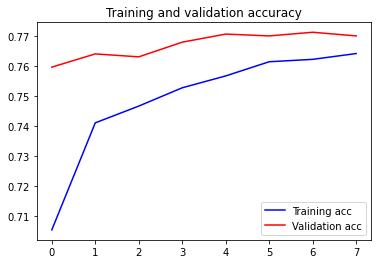

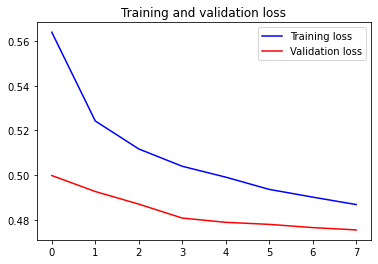

In [33]:
# 훈련 정확도와 검증 정확도 확인

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Predict

In [35]:
# 중립 라벨 설정

def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [36]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [37]:
# 긍정 문장 예측

predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9716148972511292,
 'elapsed_time': 0.2480013370513916}

In [38]:
predict('i love you')

{'label': 'POSITIVE',
 'score': 0.912096381187439,
 'elapsed_time': 0.03599405288696289}

In [39]:
# 부정 문장 예측(dont를 부정으로 예측하는지 여부)

predict("i dont love you")

{'label': 'NEGATIVE',
 'score': 0.37996840476989746,
 'elapsed_time': 0.03199958801269531}

In [40]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.009049288928508759,
 'elapsed_time': 0.03600001335144043}

In [41]:
# 중립 문장 예측

predict("he is walking")

{'label': 'NEUTRAL',
 'score': 0.4648108184337616,
 'elapsed_time': 0.04000067710876465}

In [42]:
predict("we are scared")

{'label': 'NEGATIVE',
 'score': 0.15658049285411835,
 'elapsed_time': 0.03600192070007324}

## Confusion Matrix

In [43]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

20400/20400 [==============================] - 45s 2ms/step
Wall time: 45.1 s


In [44]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

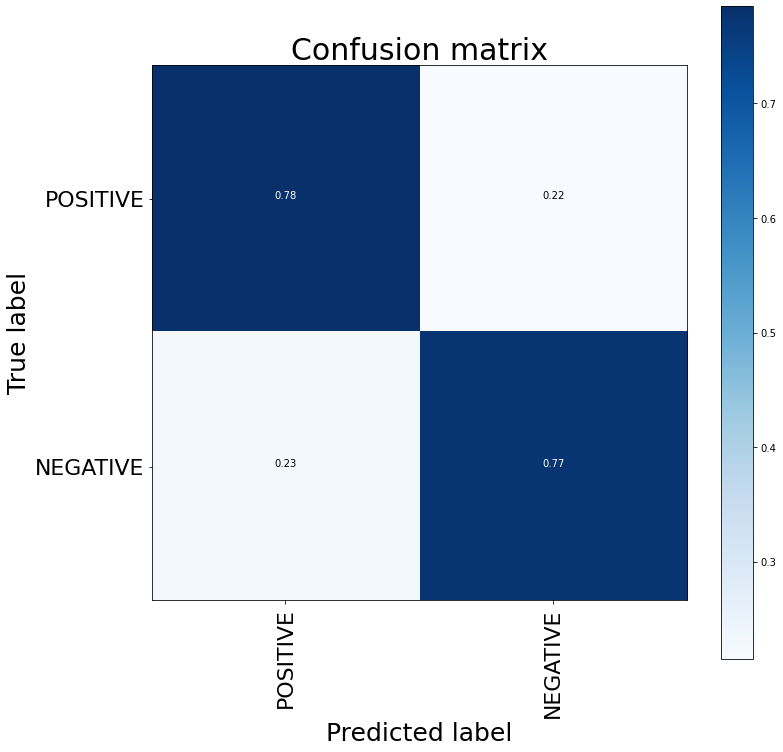

Wall time: 759 ms


In [45]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

## Classification Report

In [46]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79     10573
    POSITIVE       0.77      0.77      0.77      9827

    accuracy                           0.78     20400
   macro avg       0.78      0.78      0.78     20400
weighted avg       0.78      0.78      0.78     20400



## 정확도 점수(Accuracy Score)

In [47]:
accuracy_score(y_test_1d, y_pred_1d)

0.7788725490196079

## 작은아씨들 전처리

In [234]:
# 작은 아씨들 txt파일 불러오기

file = 'C:/Users/castl/Desktop/2020_job_academy/project/emotion_analysis/input/little_women.txt'
file_re = 'C:/Users/castl/Desktop/2020_job_academy/project/emotion_analysis/input/little_women_re.txt'

# txt안 '제거 하여 little_women_re 파일에 저장
fout=open(file_re,'w+')
with open (file,'r') as f:
    lines=f.readlines()
    for line in lines:
        line=line.replace("'","")
        fout.write(line)
    fout.close()

In [235]:
# 문장 토큰화

from nltk import sent_tokenize

data = open(file_re, 'r', encoding='utf-8')
data = data.read()
sentences = sent_tokenize(data) # 문장 토큰화

In [236]:
sentences

['Little Women\n\n\n1933, RKO Radio Pictures Inc., Directed by George Cukor, Writing \ncredits: Louisa May Alcott(novel: as Louisa M. Alcott), Sarah Y. \nMason & Vicor Heerman\n\n\n\n\n(00:02:30) \n\nMRS. MARCH\nSo youre going to Washington?',
 'MAN\nYes, Maam.',
 'My son is sick in a hospital there.',
 'MRS. MARCH\nOh.',
 'This will be an anxious Christmas for you.',
 'I think this one \nwill do.',
 'Lets try this.',
 'Is it your only son?',
 'MAN\nNo, Maam.',
 'I had four, two were killed.',
 'One is a prisoner.',
 'MRS. MARCH\nYouve done a great deal for your country, sir.',
 'MAN\nOh, not a might more than I ought to, Maam.',
 'Id go myself if I \nwas any use.',
 'Thank you for the overcoat.',
 'MRS. MARCH\nWait a minute.',
 'I hope you find him better.',
 'MAN\nThank you, Maam.',
 'God bless you.',
 'Merry Christmas.',
 'Merry \nChristmas.',
 'MRS. MARCH\nMerry Christmas.',
 '(00:03:22)**\n\nSHOP ASSISTANT\nOh, Mrs. March.',
 'Will you sign this so I can get it off?',
 'Why, \nwha

In [237]:
# 인물 별로 문장 나누기

from tensorflow.keras.preprocessing.text import text_to_word_sequence

speaker = []
text = []
token = []
for sentence in sentences:
    people = ['AMY','MEG','JO','BETH','MRS. MARCH','HANNAH','AUNT MARCH','MR. DAVIS','LAURIE','MR. LAURENCE']
    for person in people:
        if person in sentence:
            speaker.append(person)
            idx = sentence.index(person)
            text.append(sentence[idx+len(person)+1:])
            
            # 단어 토큰화
            text_to_word_sequence(sentence[idx+len(person)+1:])
            token.append(text_to_word_sequence(sentence[idx+len(person)+1:]))

In [238]:
import pandas as pd

excel_data = {'speaker': speaker,
             'text': text,
             'token': token}

df1 = pd.DataFrame(excel_data, columns=['speaker', 'text', 'token'])
df1.to_csv('C:/Users/castl/Desktop/2020_job_academy/project/emotion_analysis/new_little_women.csv')

## 작은아씨들 인물별 감성 분석

In [53]:
import pandas as pd

fname = 'C:/Users/castl/Desktop/2020_job_academy/project/emotion_analysis/score_little_women.csv'
csv = pd.read_csv(fname)
df1_new = pd.DataFrame(csv)
df1_amy = df1_new[df1_new['speaker']=='AMY']
df1_meg = df1_new[df1_new['speaker']=='MEG']
df1_jo = df1_new[df1_new['speaker']=='JO']
df1_beth = df1_new[df1_new['speaker']=='BETH']
df1_beth

,Unnamed: 0,speaker,text,token,target
43,43,BETH,"Oh, Hello.","['oh', 'hello']",2
45,45,BETH,Are they coming?,"['are', 'they', 'coming']",2
58,58,BETH,Jo.,['jo'],2
60,60,BETH,For me?,"['for', 'me']",2
64,64,BETH,I dont know.,"['i', 'dont', 'know']",2
68,68,BETH,Then _c Then Id like to spend mine for some ne...,"['then', 'c', 'then', 'id', 'like', 'to', 'spe...",2
82,82,BETH,Birds in their little nests agree.,"['birds', 'in', 'their', 'little', 'nests', 'a...",2
86,86,BETH,Look.,['look'],2
100,100,BETH,Mmm.,['mmm'],2
102,102,BETH,"Did you have a hard day, Marmee?","['did', 'you', 'have', 'a', 'hard', 'day', 'ma...",2


In [56]:
# target 뽑아내기
df1_2=df1_new[df1_new['target'].isin([0,4])]
df1_2

,Unnamed: 0,speaker,text,token,target
2,2,MRS. MARCH,"Youve done a great deal for your country, sir.","['youve', 'done', 'a', 'great', 'deal', 'for',...",4
5,5,MRS. MARCH,When I see things like that poor old man it ma...,"['when', 'i', 'see', 'things', 'like', 'that',...",0
7,7,MRS. MARCH,I couldnt bear it without them.,"['i', 'couldnt', 'bear', 'it', 'without', 'them']",4
12,12,JO,"Oh, I didnt think youd mind.","['oh', 'i', 'didnt', 'think', 'youd', 'mind']",0
13,13,AUNT MARCH,Never a thought about my Christmas.,"['never', 'a', 'thought', 'about', 'my', 'chri...",0
...,...,...,...,...,...
746,746,JO,"Oh, no, you wont, Marmee.","['oh', 'no', 'you', 'wont', 'marmee']",0
749,749,JO,I love it.,"['i', 'love', 'it']",4
753,753,JO,"Oh, no, only my family.","['oh', 'no', 'only', 'my', 'family']",0
754,754,JO,Yes.,['yes'],4


In [59]:
# 인물별 문장 긍/부정 점수 나타내기

amy = []
meg = []
jo = []
beth = []


for line in df1_amy['text']:
    amy.append(predict(line)['score'])

for line in df1_meg['text']:
    meg.append(predict(line)['score'])

for line in df1_jo['text']:
    jo.append(predict(line)['score'])

for line in df1_beth['text']:
    beth.append(predict(line)['score'])

print(amy)
print(meg)
print(jo)
print(beth)


[0.7418837547302246, 0.9797741770744324, 0.9797741770744324, 0.4301164150238037, 0.7498512268066406, 0.585390031337738, 0.5093790888786316, 0.898392915725708, 0.38045239448547363, 0.6328924894332886, 0.35837438702583313, 0.825457751750946, 0.419756144285202, 0.1127743348479271, 0.6246166825294495, 0.585390031337738, 0.7981348633766174, 0.30902183055877686, 0.9490746855735779, 0.5098567008972168, 0.9783355593681335, 0.35680195689201355, 0.32918334007263184, 0.9389338493347168, 0.7863331437110901, 0.9172662496566772, 0.7863331437110901, 0.7123851180076599, 0.6420076489448547, 0.6389973163604736, 0.6506433486938477, 0.45620012283325195, 0.585390031337738, 0.585390031337738, 0.6270785927772522, 0.7225145101547241, 0.5684270858764648, 0.585390031337738, 0.585390031337738, 0.24645574390888214, 0.29670798778533936, 0.289857417345047, 0.9254764318466187, 0.5263285636901855, 0.8543286919593811, 0.585390031337738, 0.5075131058692932, 0.8820332288742065, 0.12441498786211014, 0.308212548494339, 0.

## 작은 아씨들 평가

In [57]:
# 직은 아씨들 문장 긍 부정 정확도

z_test = pad_sequences(tokenizer.texts_to_sequences(df1_2.text), maxlen=SEQUENCE_LENGTH)
encoder.fit(df1_2.target.tolist())
zz_test=encoder.transform(df1_2.target.tolist())
zz_test = zz_test.reshape(-1,1)


score = model.evaluate(z_test, zz_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

271/271 [==============================] - 1s 4ms/step

ACCURACY: 0.8523985147476196
LOSS: 0.3405788838863373


## 시각화

Text(0, 0.5, 'Emotion')

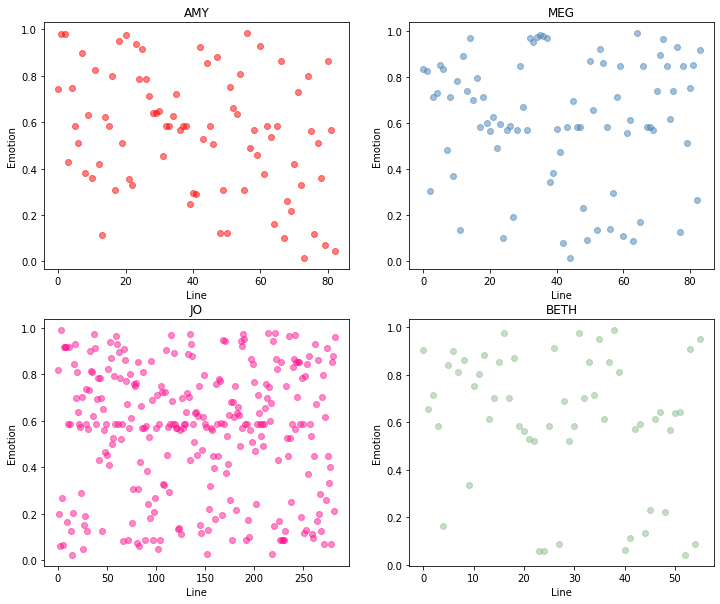

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

axes = plt.subplot(2,2,1)
x = list(range(0,len(amy)))
plt.scatter(x, amy, color='red', alpha=0.5)
plt.title('AMY')
plt.xlabel('Line')
plt.ylabel('Emotion')

axes = plt.subplot(2,2,2)
x = list(range(0,len(meg)))
plt.scatter(x, meg, color='steelblue', alpha=0.5)
plt.title('MEG')
plt.xlabel('Line')
plt.ylabel('Emotion')

axes = plt.subplot(2,2,3)
x = list(range(0,len(jo)))
plt.scatter(x, jo, color='deeppink', alpha=0.5)
plt.title('JO')
plt.xlabel('Line')
plt.ylabel('Emotion')

axes = plt.subplot(2,2,4)
x = list(range(0,len(beth)))
plt.scatter(x, beth,color='darkseagreen', alpha=0.5)
plt.title('BETH')
plt.xlabel('Line')
plt.ylabel('Emotion')